Exploring a dataset with information about patients. 
Consider next 8 features to predict the mortality rate:
1. Age
2. CHF KiLLip
3. HBR (b)
4. Systolic AP(b)
5. Creatine in blood
6. EF Percentage
7. White blood cells count
8. Glucose

# 1. Import required libraries and load the dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Load dataset
ready_data = pd.read_csv('./import/dataset_prepared.csv')

# 2. Split the dataset into features and target.

In [4]:
X = ready_data.drop('Class', axis=1)
y = ready_data['Class']

We want to consider hyper parameters, so we will use three different random_state parameters. 

In [5]:
random_states = [0, 25, 42]

# 3. Univariate linear regression 

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [7]:
def compute_importances_and_coefficients(X_train, y_train, X_test, y_test):
    """
    Compute importances and coefficients for given training and testing data.

    This function fits a Linear Regression model for each feature in the training data,
    computes r2 scores using cross validation, and returns the mean of these scores
    (used as feature importances) and the coefficients of the model.

    Args:
        X_train (pd.DataFrame): Training data features.
        y_train (pd.Series): Training data target variable.
        X_test (pd.DataFrame): Testing data features.
        y_test (pd.Series): Testing data target variable.

    Returns:
        importances (list of float): The mean r2 scores for each feature.
        coefficients (list of float): The coefficients of the Linear Regression model for each feature.
    """
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    importances = []
    coefficients = []

    for feature in X_train.columns:
        model = LinearRegression()
        model.fit(X_train_scaled[:, X_train.columns.get_loc(feature)].reshape(-1, 1), y_train) 
        scores = cross_val_score(model, 
                                 X_test_scaled[:, X_train.columns.get_loc(feature)].reshape(-1, 1), 
                                 y_test,
                                 scoring="r2", 
                                 cv=5)
        importances.append(np.mean(scores))
        coefficients.append(model.coef_[0])
    return importances, coefficients



In [8]:
def compute_average_importances_and_coefficients(X, y, skf):
    """
    Compute average importances and coefficients for given data and a StratifiedKFold object.

    This function uses StratifiedKFold cross-validation to split the data into training and testing sets,
    and then computes the importances and coefficients for each split.
    The function returns the mean importances and coefficients across all splits.

    Args:
        X (pd.DataFrame): The data features.
        y (pd.Series): The data target variable.
        skf (StratifiedKFold): The StratifiedKFold object used for cross-validation.

    Returns:
        mean_importances (list of float): The mean importances across all splits.
        mean_coefficients (list of float): The mean coefficients across all splits.
    """
    all_importances = []
    all_coefficients = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        importances, coefficients = compute_importances_and_coefficients(X_train, y_train, X_test, y_test)
        all_importances.append(importances)
        all_coefficients.append(coefficients)

    mean_importances = np.mean(all_importances, axis=0)
    mean_coefficients = np.mean(all_coefficients, axis=0)
    
    return mean_importances, mean_coefficients

In [12]:
feature_names = ["Age", "CHF KiLLip", "HBR (b)", "Systolic AP(b)", "Creatinine in blood", "EF Percentage", "White blood cells count", "Glucose"]
feature_importances = pd.DataFrame(index=feature_names)

for random_state in random_states:
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    mean_importances, mean_coefficients = compute_average_importances_and_coefficients(X, y, skf)
    feature_importances[random_state] = mean_importances
    feature_importances[str(random_state) + "_coef"] = mean_coefficients

feature_importances['mean'] = feature_importances.mean(axis=1)
feature_importances['mean_coef'] = feature_importances[[str(state) + "_coef" for state in random_states]].mean(axis=1)

In [13]:
feature_importances

,0,0_coef,25,25_coef,42,42_coef,mean,mean_coef
Age,-0.001039,0.019084,-0.024682,0.019089,-0.025595,0.019087,0.000991,0.019087
CHF KiLLip,0.019266,0.035716,-0.001367,0.035725,-0.016001,0.035707,0.018174,0.035716
HBR (b),0.029551,0.035996,-0.000332,0.036000,-0.007773,0.035983,0.021571,0.035993
Systolic AP(b),0.000224,-0.022493,-0.026721,-0.022472,-0.030183,-0.022490,-0.020689,-0.022485
Creatinine in blood,0.013652,0.037291,-0.004170,0.037051,-0.010488,0.037318,0.018442,0.037220
EF Percentage,0.036427,-0.040624,-0.010126,-0.040617,0.008502,-0.040622,-0.014510,-0.040621
White blood cells count,0.012417,0.030628,-0.010494,0.030635,-0.022674,0.030634,0.011858,0.030632
Glucose,0.002254,0.038491,0.013393,0.038456,-0.026995,0.038635,0.017372,0.038527


Draw a plot

In [16]:
def plot_weights (feature_importances, column1, column2, label1, label2, title, num_digits=3):
    barWidth = 0.25

    r1 = np.arange(len(feature_importances[column1]))
    r2 = [x + barWidth for x in r1]

    plt.figure(figsize=(13, 6))
    bars1 = plt.barh(r1, feature_importances[column1], color='blue', height=barWidth, edgecolor='grey', label=label1)
    bars2 = plt.barh(r2, feature_importances[column2], color='orange', height=barWidth, edgecolor='grey', label=label2)

    plt.yticks([r + barWidth for r in range(len(feature_importances[column1]))], feature_importances.index)

    def add_values(bars):
        for bar in bars:
            width = bar.get_width()
            plt.text(width,               
                    bar.get_y() + bar.get_height() / 2.2 ,  
                    f"{width :.{num_digits}f}",  
                    ha='left', va='center')  


    add_values(bars1)
    add_values(bars2)

    plt.xlabel('Score')
    plt.ylabel('Feature')
    plt.title(title)
    plt.legend(loc='upper left')
    plt.show()

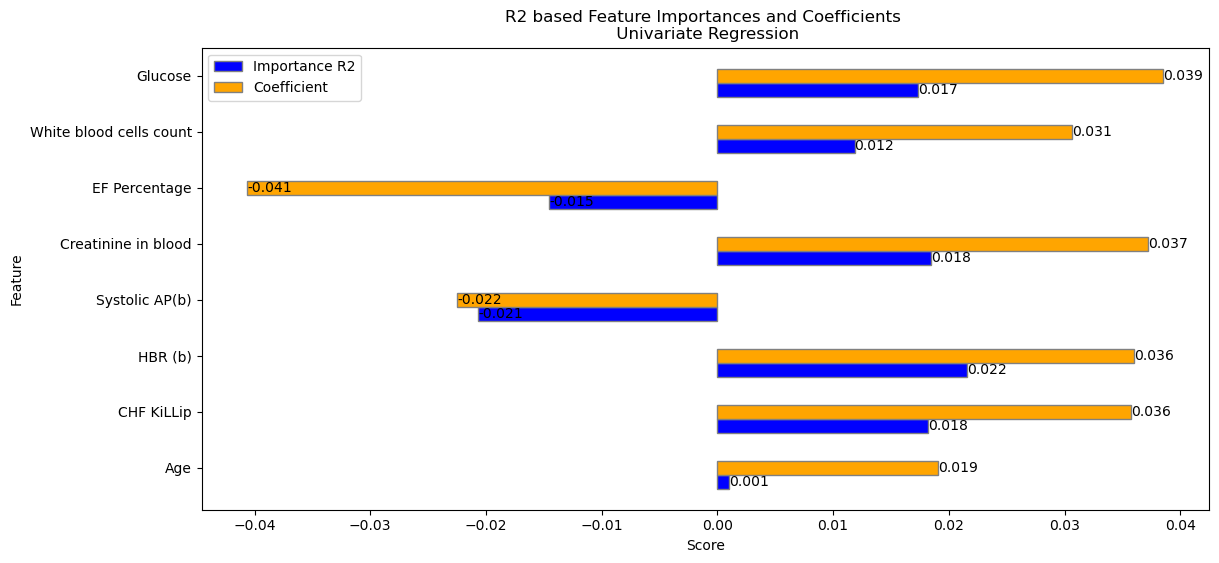

In [17]:
plot_weights(feature_importances, 'mean', 'mean_coef', label1='Importance R2', label2='Coefficient', title='R2 based Feature Importances and Coefficients \n Univariate Regression' )

## 4. Multivariate linear regression


In [11]:
import shap

feature_importances_multi = pd.DataFrame(index=feature_names)
shap_values_list = []

for random_state in random_states:
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)
    
    model = LinearRegression(fit_intercept=True, n_jobs=-1)
    model.fit(X_train, y_train)

    scores = cross_val_score(model, X_test, y_test, scoring="r2", cv=skf)
    print(f"Mean cross-validation score: {np.mean(scores): .4f} for {random_state=}")

    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_test)

    shap_values_list.append(shap_values.values)
    feature_importances_multi[random_state] = model.coef_
    feature_importances_multi[str(random_state)+"_shap"] = np.mean(np.abs(shap_values.values), axis=0)

feature_importances_multi['mean_coef'] = feature_importances_multi[[state for state in random_states]].mean(axis=1)
feature_importances_multi['mean_shap'] = feature_importances_multi[[str(state) + "_shap" for state in random_states]].mean(axis=1)

Mean cross-validation score:  0.0633 for random_state=0
Mean cross-validation score:  0.1019 for random_state=25
Mean cross-validation score:  0.1635 for random_state=42


In [66]:
feature_importances_multi

,0,0_shap,25,25_shap,42,42_shap,mean_coef,mean_shap
Age,0.000378,0.003246,0.000484,0.004312,0.000581,0.005044,0.000481,0.004200
CHF KiLLip,0.015586,0.012675,0.014749,0.011623,0.015724,0.012851,0.015353,0.012383
HBR (b),0.001419,0.016460,0.001452,0.014644,0.001236,0.014245,0.001369,0.015117
Systolic AP(b),-0.000572,0.010637,-0.000362,0.006671,-0.000408,0.007284,-0.000447,0.008197
Creatinine in blood,0.000549,0.016195,0.000569,0.017219,0.000512,0.016033,0.000543,0.016482
EF Percentage,-0.002993,0.021692,-0.002813,0.020522,-0.002522,0.017589,-0.002776,0.019934
White blood cells count,0.001969,0.006149,0.002132,0.006799,0.003968,0.012550,0.002690,0.008499
Glucose,0.009024,0.013881,0.009533,0.015325,0.008232,0.017333,0.008930,0.015513


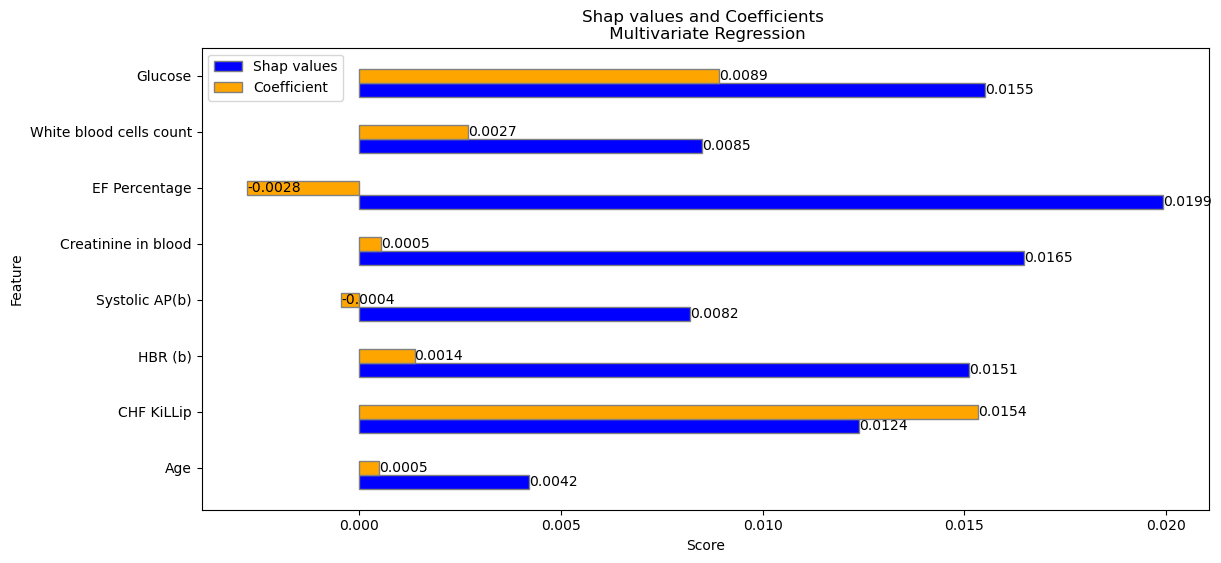

In [67]:
plot_weights(feature_importances_multi, 
             'mean_shap', 
             'mean_coef', 
             label1='Shap values', 
             label2='Coefficient', 
             title='Shap values and Coefficients \n Multivariate Regression', 
             num_digits = 4 )

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


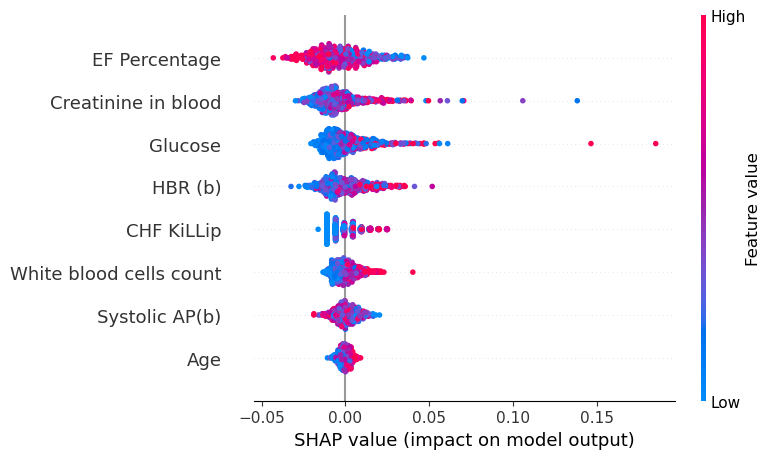

In [64]:
mean_shap_values = np.mean(shap_values_list, axis=0)
shap.summary_plot(mean_shap_values, X_test, feature_names=feature_names)